In [3]:
from astropy.io import fits
from pathlib import Path
from rasdapy.models.sinterval import SInterval
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor
import matplotlib.pyplot as plt

testPath = "data/images/301/4797/1/frame-g-004797-1-0019.fits.bz2"

def readFITSFiles():
    pathlist = Path("./data").glob('**/*.fits*')
    for path in pathlist:
        print (path)
        %timeit read_fits_file(path)
        
def read_fits_file(f_name):
    with fits.open(f_name, memmap=True) as hdul:
        data = hdul[0].data
        c = data.copy()
    
        
#readFITSFiles()
read_fits_file(testPath)

In [4]:
import csv


def read_config (config_path):
    with open (config_path) as tsv_config:
        config = []
        reader = csv.DictReader(tsv_config, dialect='excel-tab')
        for row in reader:
            config.append(row)
    return config

def get_config(config_obj, camcol, run, band):
        config_obj = list(filter (
            lambda r: r['camcol'] == str(camcol) and eval(str(run) + r['run']),
            config_obj))[0]  #there will be only one row matching the criteria
        return config_obj[band]


ccd_gain_config = read_config('config/ccd_gain.tsv')
ccd_dark_variance_config = read_config('config/ccd_dark_variance.tsv')
filter_wavelengths = {
    "u": 3551,
    "g": 4686,
    "r": 6166,
    "i": 7480,
    "z": 8932
}

print(get_config(ccd_gain_config, 1, "4797", "g"))
print(get_config(ccd_dark_variance_config, "1", "4797", "g"))
print(filter_wavelengths["u"])

    
        

3.32
15.6025
3551


In [5]:
import fitsio


def readFITSFiles():
    pathlist = Path("./data").glob('**/*.fits*')
    for path in pathlist:
        print (path)
        %timeit read_fits_file(path)

def read_fits_file(filename):
    with fitsio.FITS(filename) as f:
        print (filename)
        header = f[0].read_header()
        data = f[0].read()
        return [header, data]
        
        
#readFITSFiles()
fits_header, fits_data = read_fits_file(testPath)
camcol = fits_header['CAMCOL']
run = fits_header['run']
band = fits_header['filter']




data/images/301/4797/1/frame-g-004797-1-0019.fits.bz2


In [190]:
db_setup_sql = "setupDB.sql"
db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open()

query1 = r"""create type GaussianPixel
	as ( mean float, 
		variance float, 
		healpix_coord_variance ulong, 
		time_coord_variance float,
		spectral_coord_variance float)""";

query2 = r"""create type GaussianCube 
	as GaussianPixel mdarray [healPixID, healPixRes, time, spectral]""";

query3 = r"""create type GaussianCubeSet 
	as set (GaussianCube)""";

query4 = r"""create collection cube GaussianCubeSet""";

query5 = r"""select r from RAS_COLLECTIONNAMES as r """;


with open(db_setup_sql, 'r') as file:
    query = file.read()
try:
    #query_executor.execute_write(query1)
    #query_executor.execute_write(query2)
    #query_executor.execute_write(query3)
    #query_executor.execute_write(query4)
    
    
    result = query_executor.execute_read(query5)
    #numpy_array = result.to_array()
    print(result)
finally:
    db_connector.close()



In [6]:
import numpy as np
from astropy import wcs
from astropy.io import fits
import sys


w = wcs.WCS(fits_header)

ra, dec = w.wcs_pix2world(0., 0., 1)
p2x, p2y = w.all_pix2world(0., 0., 1)

print ("px: %f py: %f" %(ra,dec))
print ("p2x: %f p2y: %f" %(p2x,p2y))

px: 308.634028 py: -1.057123
p2x: 308.634028 p2y: -1.057123


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [14]:
import healpy as hp
RES_ORDER = 19
NSIDE = 2**RES_ORDER


time_epoch = fits_header["TAI"]
band = fits_header["FILTER"]
spec = filter_wavelengths[band]
res = RES_ORDER

print (time_epoch)
print (spec)
print(res)



for index, pix in np.ndenumerate(fits_data):
    if (index[0] == 0 and index[1] == 0):
        ra, dec = w.wcs_pix2world(index[0], index[1], 1)
        print ("px: %f py: %f" %(ra,dec))
        pixelID = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
    

#np.array()

#print (pixel)
print(fits_data.shape)


4600217209.9
4686
19
px: 308.634028 py: -1.057123
(1489, 2048)


In [192]:
query1 = r"""insert into cube values marray it in [0:0, 0:0, 0:0, 0:0] values {0.0f, 0.0f, 0ul, 0.0f, 0.0f} """;

try:
    db_connector.open()
    query_executor.execute_write(query1)    
finally:
    db_connector.close()

<class 'numpy.ndarray'>
(1489, 2048)


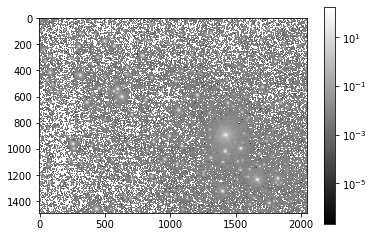

In [111]:
print (type(fits_data))
print(fits_data.shape)
from matplotlib.colors import LogNorm



plt.imshow(fits_data, cmap='gray', norm=LogNorm())
plt.colorbar()

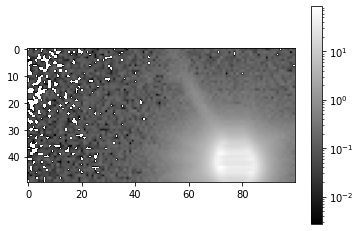

In [117]:
fits_subset = fits_data[850:900, 1350:1450]

plt.imshow(fits_subset, cmap='gray', norm=LogNorm())
plt.colorbar()